# Costa Rican Household Poverty Level Prediction 

Develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. 

## Problem and Data Explanation

The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

This is a supervised multi-class classification machine learning problem:

Supervised: provided with the labels for the training data
Multi-class classification: Labels are discrete values with 4 classes

## Objective
The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0. We will cover how to correct this in the notebook (for more info take a look at the competition main discussion).

The Target values represent poverty levels as follows:

__1 = extreme poverty__<br> 
__2 = moderate poverty__ <br> 
__3 = vulnerable households__<br> 
__4 = non vulnerable households__<br>

## Data Descriptions
The explanations for all 143 columns can be found in the competition documentation, but a few to note are below:

Id: a unique identifier for each individual, this should not be a feature that we use.

idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.

parentesco1: indicates if this person is the head of the household.

Target: the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job.

## Metric
Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the __Macro F1 Score__. You may be familiar with the standard F1 score for binary classification problems which is the harmonic mean of precision and recall:

F1=21recall+1precision=2⋅precision⋅recallprecision+recall
 
For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

Macro F1=F1 Class 1+F1 Class 2+F1 Class 3+F1 Class 44
 
In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). (For more information on the differences, look at the Scikit-Learn Documention for F1 Score or this Stack Exchange question and answers. If we want to assess our performance, we can use the code:

from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro`)
For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly.

## Roadmap
The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our roadmap is therefore as follows:

- Understand the problem (we're almost there already)
- Exploratory Data Analysis
- Feature engineering to create a dataset for machine learning
- Compare several baseline machine learning models
- Try more complex machine learning models
- Optimize the selected model
- Investigate model predictions in context of problem
- Draw conclusions and lay out next steps

The steps laid out above are iterative meaning that while we will go through them one at a time, we might go back to an earlier step and revisit some of our decisions. In general, data science is a non-linear pracice where we are constantly evaluating our past decisions and making improvements. In particular, feature engineering, modeling, and optimization are steps that we often repeat because we never know if we got them right the first time!

### Getting Started
For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quantitatively (with statistics) and visually (with figures).

Once we have a good grasp of the data and any potentially useful relationships, we can do some feature engineering (the most important part of the machine learning pipeline) and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on!

With all that info in mind (don't worry if you haven't got all the details), let's get started!

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
#Read in Data and look at Summary Information
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0,100,1849,4
1,ID_f29eb3ddd,135000,0,4,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64,144,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64,121,8464,4
3,ID_d671db89c,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,9,1,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1,121,289,4
4,ID_d56d6f5f5,180000,0,5,0,1,1,1,1,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1,121,1369,4


In [4]:
train.shape

(9557, 143)

In [5]:
test.shape

(23856, 142)

In [112]:
test

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.500000,1,0,0,0,0,0,0,0,0,2,1.500000,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.250000,0.25,272.250000,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.500000,0,0,0,0,0,0,0,1,0,2,1.500000,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.250000,0.25,272.250000,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.500000,0,0,0,0,0,0,0,0,1,2,1.500000,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.250000,0.25,272.250000,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,no,16,no,16.000000,0,0,0,0,0,0,0,1,0,1,1.000000,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.000000,0.00,256.000000,3481
4,ID_a62966799,175000,0,4,0,1,1,1,1,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.500000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.250000,64.00,NaN,324
5,ID_e77d38d45,400000,0,3,0,1,1,1,1,0,0,0,0,2,2,0,2,2,2,2,16,NaN,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,8ee7365a8,0,2,0,2,no,no,11,13.500000,0,0,0,0,0,0,0,1,0,2,1.000000,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,38,256,1444,4,0,0,1.000000,0.00,182.250000,1444
6,ID_3c5f4bd51,400000,0,3,0,1,1,1,1,0,0,0,0,2,2,0,2,2,2,2,11,NaN,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,8ee7365a8,0,2,0,2,no,no,11,13.500000,0,0,0,0,1,0,0,0,0,2,1.000000,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,42,121,1764,4,0,0,1.000000,0.00,182.250000,1764
7,ID_a849c29bd,300000,0,6,0,1,1,1,1,0,0,0,0,2,2,0,2,2,2,2,14,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0

In [5]:
Ids = test['Id'].unique()
Ids

array(['ID_2f6873615', 'ID_1c78846d2', 'ID_e5442cf6a', ...,
       'ID_07dbb4be2', 'ID_34d2ed046', 'ID_34754556f'], dtype=object)

In [4]:
test.groupby('SQBescolari').describe()

SQBage  SQBdependency    SQBedjefe  SQBhogar_nin  \
SQBescolari                                                                
0           count  3162.000000    3162.000000  3162.000000   3162.000000   
            mean    916.534156       5.123819    43.387413      6.876660   
            std    1958.311676      13.309961    68.288288     10.266704   
            min       0.000000       0.000000     0.000000      0.000000   
            25%       4.000000       0.250000     0.000000      1.000000   
            50%      25.000000       1.000000     9.000000      4.000000   
            75%      49.000000       2.777778    49.000000      9.000000   
            max    9409.000000      64.000000   441.000000    100.000000   
1           count   717.000000     717.000000   717.000000    717.000000   
            mean   1622.079498       7.515353    33.407252      5.709902   
            std    2341.437951      17.648653    60.264282      8.539561   
            min      49.000000       0.000000     0.000000      0.000000   
            25%      64.000000       0.444444     0.000000      1.000000   
            50%      64.000000       1.000000     1.000000      4.000000   
            75%    3025.000000       4.000000    36.000000      9.000000   
            max    9409.000000      64.000000   441.000000     81.000000   
4           count   769.000000     769.000000   769.000000    769.000000   
            mean   1904.262679       7.388606    28.566970      5.189857   
            std    2377.714605      17.464749    55.343398      7.798761   
            min      64.000000       0.000000     0.000000      0.000000   
            25%      81.000000       0.250000     0.000000      0.000000   
            50%     121.000000       1.000000     4.000000      4.000000   
            75%    3721.000000       4.000000    36.000000      9.000000   
            max    9409.000000      64.000000   441.000000     64.000000   
9           count  1051.000000    1051.000000  1051.000000   1051.000000   
            mean   2288.125595       8.118313    31.095147      5.216936   
            std    2351.335278      18.554942    61.585283      9.856230   
            min      81.000000       0.000000     0.000000      0.000000   
            25%     100.000000       0.250000     0.000000      0.000000   
            50%    1600.000000       1.000000     9.000000      1.000000   
...                        ...            ...          ...           ...   
324         std    1154.365233      22.623072   149.413058      1.197219   
            min    1849.000000       0.000000     0.000000      0.000000   
            25%    2304.000000       0.000000     0.000000      0.000000   
            50%    3136.000000       0.444444   289.000000      0.000000   
            75%    3844.000000       4.000000   324.000000      1.000000   
            max    5476.000000      64.000000   324.000000      4.000000   
361         count    17.000000      17.000000    17.000000     17.000000   
            mean   2530.647059       4.583350   235.529412      1.588235   
            std    1257.859339      15.459966   165.706109      1.872793   
            min     784.000000       0.000000     0.000000      0.000000   
            25%    1444.000000       0.000000     0.000000      0.000000   
            50%    2704.000000       0.160000   361.000000      1.000000   
            75%    3249.000000       1.000000   361.000000      4.000000   
            max    5625.000000      64.000000   361.000000      4.000000   
400         count    12.000000      12.000000    12.000000     12.000000   
            mean   2954.916667       0.506944   281.750000      1.666667   
            std    1578.145313       0.683615   169.961560      2.741378   
            min     961.000000       0.000000     0.000000      0.000000   
            25%    1723.000000       0.083333   201.000000      0.000000   
            50%    2654.500000       0.180556   400.000000      0.500000

In [29]:
train.groupby('SQBescolari').describe()

SQBage  SQBhogar_total  SQBovercrowding       Target
SQBescolari                                                                 
0           count  1307.000000     1307.000000      1307.000000  1307.000000
            mean    881.138485       23.785769         4.683694     2.931905
            std    1929.453997       22.459288         5.243667     1.126372
            min       0.000000        1.000000         0.111111     1.000000
            25%       4.000000        9.000000         1.777778     2.000000
            50%      25.000000       16.000000         2.777778     3.000000
            75%      49.000000       25.000000         5.444444     4.000000
            max    9409.000000      169.000000        36.000000     4.000000
1           count   247.000000      247.000000       247.000000   247.000000
            mean   1705.890688       20.761134         4.391207     2.870445
            std    2488.956744       20.165666         5.377242     1.125922
            min      49.000000        1.000000         0.111111     1.000000
            25%      64.000000        9.000000         1.000000     2.000000
            50%      64.000000       16.000000         2.777778     3.000000
            75%    2970.500000       25.000000         4.000000     4.000000
            max    9409.000000      169.000000        36.000000     4.000000
4           count   318.000000      318.000000       318.000000   318.000000
            mean   1913.610063       21.169811         3.972415     2.959119
            std    2337.893881       21.881876         5.107728     1.112686
            min      64.000000        1.000000         0.111111     1.000000
            25%      81.000000        9.000000         1.000000     2.000000
            50%     100.000000       16.000000         2.250000     3.000000
            75%    3600.000000       25.000000         4.000000     4.000000
            max    8836.000000      169.000000        36.000000     4.000000
9           count   401.000000      401.000000       401.000000   401.000000
            mean   2499.860349       18.029925         3.548166     2.927681
            std    2444.240121       18.882905         4.773754     1.091905
            min      81.000000        1.000000         0.062500     1.000000
            25%     100.000000        4.000000         1.000000     2.000000
            50%    1849.000000       16.000000         2.250000     3.000000
...                        ...             ...              ...          ...
324         std    1506.776639        4.015595         0.708134     0.000000
            min    1024.000000        4.000000         0.360000     4.000000
            25%    1369.000000        9.000000         0.532986     4.000000
            50%    1849.000000        9.000000         1.000000     4.000000
            75%    2425.750000       10.750000         1.777778     4.000000
            max    5776.000000       16.000000         2.250000     4.000000
361         count     9.000000        9.000000         9.000000     9.000000
            mean   3125.666667       11.555556         2.895062     4.000000
            std    1923.406418       14.151953         3.642195     0.000000
            min    1156.000000        1.000000         0.111111     4.000000
            25%    1764.000000        4.000000         0.694444     4.000000
            50%    2601.000000        4.000000         1.000000     4.000000
            75%    3481.000000        9.000000         4.000000     4.000000
            max    7569.000000       36.000000         9.000000     4.000000
400         count     4.000000        4.000000         4.000000     4.000000
            mean   3496.250000        8.250000         1.835069     4.000000
            std    1814.419352        5.678908         1.528287     0.000000
            min    1849.000000        4.000000         0.562500     4.000000
            25%    2649.250000        4.000000         0.890625     4.000000
            50%    3

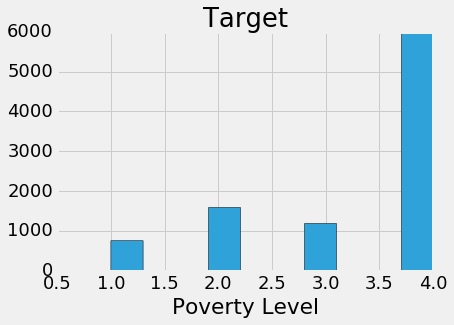

In [15]:
#Let's look at the distribution of the 'Target' variable from the training data
fig=plt.figure(figsize=(10,10))
train.hist(column='Target')
plt.xlabel('Poverty Level')

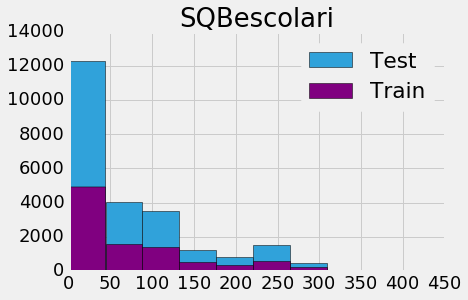

In [6]:
#Now let's compare a few variables in the training and test datasets.

x = test['SQBescolari']
y = train['SQBescolari']

from matplotlib import pyplot
pyplot.hist(x, label='Test')
pyplot.hist(y, label='Train',color='purple')
pyplot.legend(loc='upper right')
pyplot.title('SQBescolari')
pyplot.show()

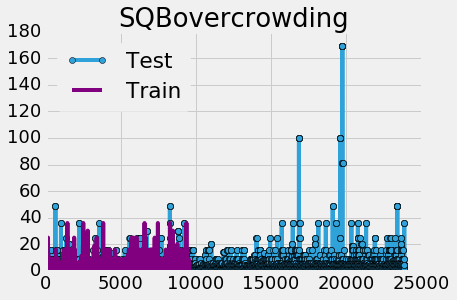

In [7]:
#To explore SQBovercrowding variable, a histogram won't show enough info so let's do a line plot
x = test['SQBovercrowding']
y = train['SQBovercrowding']

from matplotlib import pyplot as plt

plt.plot(x, label='Test', marker='o')
plt.plot(y, label='Train',color='purple')
plt.legend(loc='upper left')
plt.title('SQBovercrowding')
plt.show()

#Well that isn't extremely helpful since there don't appear to be any patterns. 

#Let's look at the outlier data points a bit more in each of the Test and Training data sets.

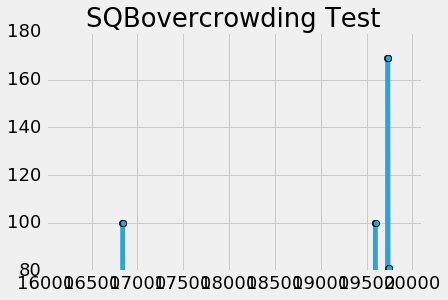

In [8]:
#Let's zoom in on the test outliers by changing the x and y axis limits
plt.plot(x, label='Test', marker='o')
plt.xlim(16000,20100)
plt.ylim(80,180)
plt.title('SQBovercrowding Test')
plt.show()

#The outlier values in the test dataset seem to be 100 and 170.
#Most values in the training dataset are between 0-40; and 0-50 in the test dataset.

In [9]:
#Let's look more closely at the variable 'SQBescolari' (square years of education) that has values 0, 1, 4 and 9
#And where the Target is 1 or 2 (extreme or moderate poverty)

SQBescolari_train = train.query('SQBescolari <=9' and 'Target <=2')
SQBescolari_train

#There are 755 with Target of 1, 1597 with Target of 2, and 2352 with either 1 or 2 
#out of the total train sample size of 9553.

#We still don't know if the 'SQBage' or 'SQBhogar_total' are significant variables so let's keep for now.

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
50,ID_eb1d477b3,120000,0,5,0,1,1,0,NaN,0,1,1,1,2,3,1,3,4,4,4,2,0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,652a7ffa0,2,2,0,4,yes,11,no,11.00,0,1,0,0,0,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,8,4,64,16,121,4,4.000000,1.0000,121.0000,64,2
51,ID_1edc6734e,120000,0,5,0,1,1,0,NaN,0,1,1,1,2,3,1,3,4,4,4,11,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,652a7ffa0,2,2,0,4,yes,11,no,11.00,0,0,0,0,1,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,44,121,1936,16,121,4,4.000000,1.0000,121.0000,1936,2
52,ID_68cdfd374,120000,0,5,0,1,1,0,NaN,0,1,1,1,2,3,1,3,4,4,4,8,0,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,652a7ffa0,2,2,0,4,yes,11,no,11.00,0,0,0,1,0,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,14,64,196,16,121,4,4.000000,1.0000,121.0000,196,2
53,ID_be0fdb30f,120000,0,5,0,1,1,0,NaN,0,1,1,1,2,3,1,3,4,4,4,11,NaN,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,652a7ffa0,2,2,0,4,yes,11,no,11.00,0,0,0,0,1,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,42,121,1764,16,121,4,4.000000,1.0000,121.0000,1764,2
58,ID_a0fb0a5c4,40000,0,1,0,0,0,0,NaN,0,1,1,0,0,0,0,1,1,1,1,7,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,09a26c158,0,1,1,1,8,7,no,7.00,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,71,49,5041,1,49,0,1.000000,64.0000,49.0000,5041,2
64,ID_6e9d356d7,NaN,0,6,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,9,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,d9281c805,0,1,1,1,8,no,9,9.00,0,0,0,1,0,0,0,0,0,3,0.333333,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,71,81,5041,1,0,0,0.111111,64.0000,81.0000,5041,2
121,ID_fdf18bbee,NaN,0,5,0,1,1,0,NaN,0,1,1,0,4,4,0,5,5,5,5,14,NaN,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,d9e9b591a,0,5,1,5,.25,no,no,9.00,0,0,0,0,0,0,0,1,0,3,1.666667,1,0,0,0,0,0,0,1,3,1,0,0,0,0,0,1,0,21,196,441,25,0,0,2.777778,0.0625,81.0000,441,2
122,ID_cba836ed8,NaN,0,5,0,1,1,0,NaN,0,1,1,0,4,4,0,5,5,5,5,8,NaN,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,

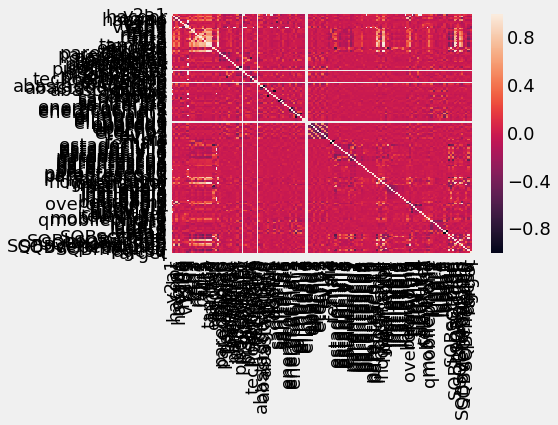

In [10]:
#Explore relationship between 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBovercrowding' and 'Target'
#Output feature in training dataset

import seaborn as sns

#Calculate the correlation matrix
corr = SQBescolari_train.corr()

#Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

#From the heatmap, we see 'SQBage' and 'SQBhogar_total' have 0 correlation so these variables can be deleted.

#SQBescolari is positively correlated (0.4) and 'SQBovercrowding' is highly negatively correlated (-0.25)

In [126]:
trainclean = SQBescolari_train[['Id','SQBescolari', 'SQBovercrowding']]
trainclean

,Id,SQBescolari,SQBovercrowding
0,ID_279628684,100,1.000000
1,ID_f29eb3ddd,144,1.000000
2,ID_68de51c94,121,0.250000
3,ID_d671db89c,81,1.777778
4,ID_d56d6f5f5,121,1.777778
5,ID_ec05b1a7b,121,1.777778
6,ID_e9e0c1100,4,1.777778
11,ID_de822510c,144,1.000000
12,ID_d94071d7c,121,1.000000
13,ID_064b57869,16,1.000000


## Continue Exploratory Data Analysis with Test Data

In [106]:
test.groupby('SQBovercrowding').describe()

SQBage  SQBdependency   SQBedjefe  SQBescolari  \
SQBovercrowding                                                              
0.020408        count     2.000000       2.000000    2.000000     2.000000   
                mean   5284.000000      32.000000   18.000000    78.500000   
                std    2036.467530      45.254834   25.455844    60.104076   
                min    3844.000000       0.000000    0.000000    36.000000   
                25%    4564.000000      16.000000    9.000000    57.250000   
                50%    5284.000000      32.000000   18.000000    78.500000   
                75%    6004.000000      48.000000   27.000000    99.750000   
                max    6724.000000      64.000000   36.000000   121.000000   
0.027778        count     1.000000       1.000000    1.000000     1.000000   
                mean   6724.000000      64.000000    0.000000   121.000000   
                std            NaN            NaN         NaN          NaN   
                min    6724.000000      64.000000    0.000000   121.000000   
                25%    6724.000000      64.000000    0.000000   121.000000   
                50%    6724.000000      64.000000    0.000000   121.000000   
                75%    6724.000000      64.000000    0.000000   121.000000   
                max    6724.000000      64.000000    0.000000   121.000000   
0.040000        count     6.000000       6.000000    6.000000     6.000000   
                mean   5488.666667      64.000000   49.333333   109.666667   
                std    1357.080494       0.000000  102.220676   109.735439   
                min    4489.000000      64.000000    0.000000     4.000000   
                25%    4591.750000      64.000000    0.000000    21.000000   
                50%    5114.500000      64.000000    2.000000    78.500000   
                75%    5551.000000      64.000000   28.000000   199.000000   
                max    8100.000000      64.000000  256.000000   256.000000   
0.062500        count    35.000000      35.000000   35.000000    35.000000   
                mean   4421.742857      36.571429   39.771429    96.800000   
                std    2012.356876      32.134172   68.669321    83.374703   
                min     625.000000       0.000000    0.000000     0.000000   
                25%    3137.000000       0.000000    0.000000    36.000000   
                50%    4624.000000      64.000000    0.000000    81.000000   
...                            ...            ...         ...          ...   
49.000000       std    1145.615560       2.929851   47.594982    46.094022   
                min       0.000000       0.160000    0.000000     0.000000   
                25%      36.000000       0.562500    0.000000     0.000000   
                50%     289.000000       6.250000    0.000000    16.000000   
                75%    1124.500000       6.250000   25.000000    36.000000   
                max    5184.000000       6.250000  121.000000   169.000000   
81.000000       count     9.000000       9.000000    9.000000     9.000000   
                mean    242.111111      64.000000    0.000000    21.444444   
                std     407.952646       0.000000    0.000000    23.564333   
                min       0.000000      64.000000    0.000000     0.000000   
                25%      16.000000      64.000000    0.000000     0.000000   
                50%     121.000000      64.000000    0.000000     9.000000   
                75%     196.000000      64.000000    0.000000    49.000000   
                max    1296.000000      64.000000    0.000000    49.000000   
100.000000      count    20.000000      20.000000   20.000000    20.000000   
                mean    423.450000      10.722222   12.500000    14.850000   
                std     762.854023       5.414886   12.824729    24.805082   
                min       0.000000       5.444444    0.000000     0.000000   
                25%      14.250000       5.444444 

In [11]:
#From looking at the training dataset above, we see Target of 1 or 2 when 'SQBovercrowding' has values between 
#0.111 and 12.25 so let's query with this in mind.

SQBescolari_test= test.query('SQBescolari <=9')
SQBescolari_test

#3162 have 0 years SQBescolari, 3879 1 years, 769 have 4 years, 1051 have 9 years out of 23856 test sample size.
##(about 37% of total sample size)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,.5,no,17,16.500000,1,0,0,0,0,0,0,0,0,2,1.500000,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.250000,0.250000,272.250000,16
24,ID_13f752d2b,210000,0,5,0,1,1,1,2,0,1,1,2,1,3,2,2,4,4,4,0,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,23eb5e435,2,2,0,4,yes,11,no,11.000000,1,0,0,0,0,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,3,0,9,16,121,4,4.000000,1.000000,121.000000,9
27,ID_47e48cb8f,210000,0,5,0,1,1,1,2,0,1,1,2,1,3,2,2,4,4,4,0,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,23eb5e435,2,2,0,4,yes,11,no,11.000000,1,0,0,0,0,0,0,0,0,2,2.000000,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,6,0,36,16,121,4,4.000000,1.000000,121.000000,36
39,ID_67c0283d8,275000,0,5,0,1,1,0,NaN,0,2,2,1,2,3,1,4,5,5,5,3,NaN,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0e00a3d3c,1,4,0,5,.25,6,no,5.750000,0,1,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,1,1,1,4,1,0,0,0,0,0,1,0,58,9,3364,25,36,1,2.777778,0.062500,33.062500,3364
40,ID_3feb0af61,275000,0,5,0,1,1,0,NaN,0,2,2,1,2,3,1,4,5,5,5,0,NaN,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0e00a3d3c,1,4,0,5,.25,6,no,5.750000,1,0,0,0,0,0,0,0,0,3,1.666667,0,0,1,0,0,1,1,1,4,1,0,0,0,0,0,1,0,1,0,1,25,36,1,2.777778,0.062500,33.062500,1
46,ID_e94e78175,170000,0,5,0,1,1,0,NaN,1,2,3,0,2,2,1,4,5,5,5,0,NaN,5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,c2174ada3,1,4,0,5,.25,no,6,7.500000,1,0,0,0,0,0,0,0,0,2,2.500000,0,0,1,0,0,0,0,1,4,1,0,0,0,0,0,1,0,6,0,36,25,0,1,6.250000,0.062500,56.250000,36
53,ID_b53f40f79,90000,0,4,0,1,1,0,NaN,2,1,3,2,1,3,4,2,6,6,6,0,NaN,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,a6af97626,4,2,0,6,2,11,no,8.000000,1,0,0,0,0,0,0,0,0,3,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,4,0,16,36,121,16,4.000000,4.000000,64.000000,16
54,ID_05c88e71d,90000,0,4,0,1,1,0,NaN,2,1,3,2,1,3,4,2,6,6,6,0,NaN,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0

In [12]:
#Now let's find unique values for SQBovercrowding
SQBescolari_test.SQBovercrowding.unique()

array([2.2500000e+00, 4.0000000e+00, 2.7777777e+00, 6.2500000e+00,
       1.7777779e+00, 4.8400002e+00, 7.1111116e+00, 2.5000000e-01,
       4.4444448e-01, 1.0000000e+00, 1.6000000e+01, 9.0000000e+00,
       1.9599999e+00, 1.4400001e+00, 5.6250000e-01, 5.4444442e+00,
       1.5625000e+00, 4.9000000e+01, 1.2250000e+01, 6.4000005e-01,
       1.1111112e-01, 3.0625000e+00, 3.6000000e+01, 7.3673463e+00,
       2.5000000e+01, 2.0250000e+01, 3.2399998e+00, 2.5600002e+00,
       6.2500000e-02, 5.0625000e+00, 1.1111111e+01, 1.3444445e+01,
       1.6000001e-01, 7.6562500e-01, 6.9444442e-01, 3.3611112e+00,
       3.0250000e+01, 1.8777779e+01, 1.3611110e+00, 5.7600002e+00,
       5.1020408e-01, 1.4062500e+01, 3.6000001e-01, 1.3061225e+00,
       1.0000000e+02, 1.6900000e+02, 8.1000000e+01, 4.0000003e-02])

In [14]:
#Clean up SQBescolari_test dataframe to get rid of unnecessary columsn
testclean = SQBescolari_test[['Id','SQBescolari', 'SQBovercrowding']]
testclean

,Id,SQBescolari,SQBovercrowding
0,ID_2f6873615,0,2.250000
24,ID_13f752d2b,0,4.000000
27,ID_47e48cb8f,0,4.000000
39,ID_67c0283d8,9,2.777778
40,ID_3feb0af61,0,2.777778
46,ID_e94e78175,0,6.250000
53,ID_b53f40f79,0,4.000000
54,ID_05c88e71d,0,4.000000
56,ID_5fbc29474,0,4.000000
66,ID_bcfc06cdd,4,4.000000


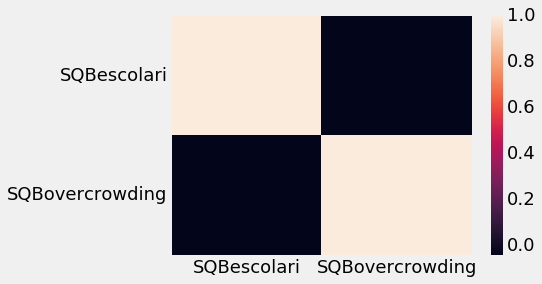

In [15]:
#Let's see if we can visualize the relationship (if any) between SQBescolari & SQBovercrowding

import seaborn as sns

#Calculate the correlation matrix
corr = testclean.corr()

#Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

#It appears that the two variables are highly linearly correlated.

## Duplicate Features

- 'SQBage' and 'agesq' are duplicates of 'age'
- 'SQBedjefe', 'edjefe'[101] and 'SQBmeaned' are duplicate metrics of 'SQBescolari'
- 'SQBhogar_nin' is duplicate metric of 'SQBhogar_total'

In [16]:
#Build a quick baseline Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Define input and output features
ytrain = train.iloc[:,-1] #Define target variable as last column of data frame (see https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
Xtrain = train.drop('Target', axis=1)

#Fill NAs
Xtrain = Xtrain.fillna(-999)

#label encoder
for c in train.columns[train.dtypes == 'object']:
    Xtrain[c] = Xtrain[c].factorize()[0]

rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
#Test the model

#Create a copy to work with
Xtest = test.copy()

#Save and drop labels
ytest = Xtrain
Xtest = Xtrain.iloc[0:141]

#Fill NAs
Xtest = Xtest.fillna(-999)

#Make the prediction
ypredictions = rf.predict(ytest)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print("=== Confusion Matrix ===")
print(confusion_matrix(ytest, ypredictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(ytest, ypredictions))
print('\n')

=== Confusion Matrix ===


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [105]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rf_random.fit(X_train, y_train)
# print results
print(rf_random.best_params_)

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 300}


In [108]:
#Random Forest Classifier Model Metrics

# Use the forest's predict method on the test data
predictions = rf.predict(Xtest)
# Calculate the absolute errors
errors = abs(predictions - ytest)

#Macro F1 Score is Model Evaluation Metric
from sklearn.metrics import f1_score

print("=== Macro F1 Score ===")
f1_score (ytrain, ypredictions, average='macro')

=== Macro F1 Score ===


0.9976441983959405

In [109]:
#Now add these tuned parameters to the model to see if we can improve results
rfc = RandomForestClassifier(n_estimators=1000, max_depth=300, max_features='auto')
rfc.fit(Xfeatures_train,yfeatures_train)
rfc_predict = rfc.predict(Xfeatures_test)

print("=== Macro F1 Score ===")
f1_score (ytrain, ypredictions, average='macro')

#Notice there is no change in the macro F1 score with hypertuned parameters.

=== Macro F1 Score ===


0.9976441983959405

More Exploratory Data Analysis - Feature Selection

NameError: name 'vertical' is not defined

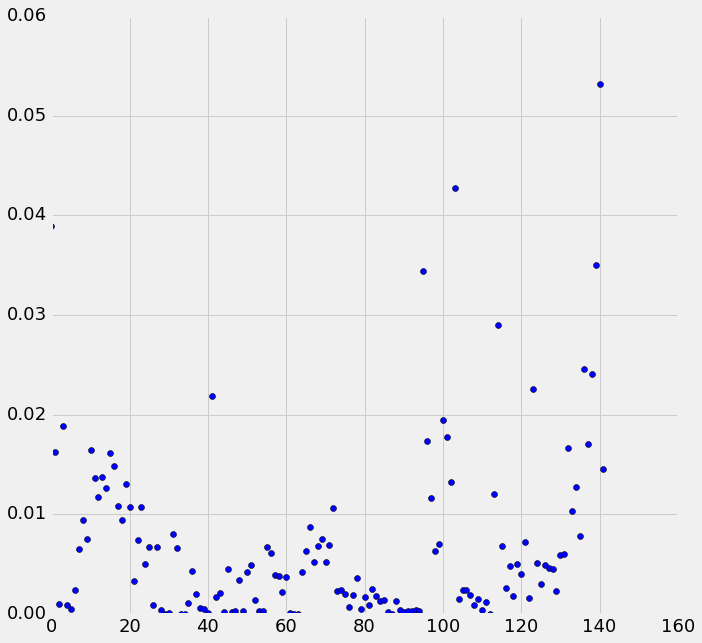

In [298]:
#Plot Feature Importance
plt.figure(figsize=(10,10)) #Increased figure size to see which features are most interesting
plt.plot(rf.feature_importances_, 'bo') #change to points to see individual feature points.
plt.xticks(np.arange(Xtrain.shape[1], Xtrain.columns.tolist, rotation=vertical))
plt.xlabel('Features')
plt.xlim(90,140)
plt.show()
#TLet's take a closer look at the outliers to see which features might affect the model the most.

In [27]:
import numpy as np
np.set_printoptions(threshold=np.inf)  #https://stackoverflow.com/questions/1987694/how-to-print-the-full-numpy-array

print("-Here are the predicted Poverty Level Targets-")
ypredictions

-Here are the predicted Poverty Level Targets-


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [29]:
#Read in Results Data
submission = pd.read_csv('CR_Kaggle_LKahn.csv')
submission.head(5)

,Id,Target
0,ID_279628684,4
1,ID_f29eb3ddd,4
2,ID_68de51c94,4
3,ID_d671db89c,4
4,ID_d56d6f5f5,4


In [30]:
submission.to_csv('./Submission_log_RF.csv', columns=['Id', 'Target'], index=False)

In [144]:
#Next, let's try a NN to see if we can improve F1 macro score
from sklearn.neural_network import MLPClassifier

#Create a copy to work with
Xtrain = train.copy()

#Save and drop labels
ytrain = Xtrain.iloc[:,-1] #Define target variable as last column of data frame (see https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
Xtrain = Xtrain.drop('Target', axis=1)

#Fill NAs
Xtrain = Xtrain.fillna(-999)

#label encoder
for c in train.columns[train.dtypes == 'object']:
    Xtrain[c] = Xtrain[c].factorize()[0]

MLP= MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2),random_state=1)
MLP.fit(Xtrain,ytrain)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)